In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
import scipy.io
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import minimum_filter1d
from scipy.ndimage.filters import convolve1d
from scipy.signal import medfilt
from six.moves import urllib
import os
import sklearn.decomposition
import warnings
warnings.simplefilter('ignore')

In [2]:
# download 2-photon data
if not os.path.isfile('data/MP019.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/MP019.npy') as response:
        with open('data/MP019.npy','wb') as f:
            f.write(response.read())

dat = np.load('data/MP019.npy')
dat = dat.item() # <- dat is a dict so we have to do this

In [3]:
# DATA preprocessing
# we need to baseline and deconvolve the calcium fluorescence data

from scipy.ndimage import filters

F = dat['F']

ops = {}
# baseline fluorescence traces recorded with 2p calcium imaging
ops['sig_baseline'] = 10  # adjust this to get desired result
ops['win_baseline'] = 80 # adjust this to get desired result
ops['fs'] = 5

sig = ops['sig_baseline']
win = int(ops['win_baseline']*ops['fs'])    

# smooth the data first, to remove high-frequency noise
Flow = gaussian_filter1d(F, sig)
# now run a minimum filter
# Flow = minimum_filter1d(Flow,    win)
# now run a maximum filter
# Flow = maximum_filter1d(Flow,    win)

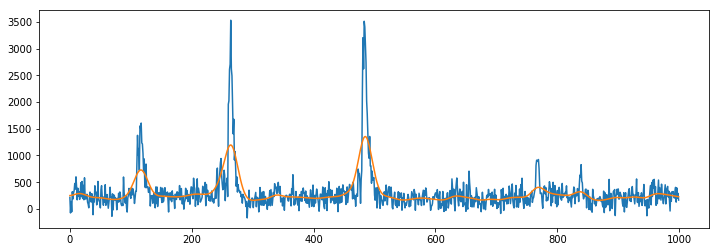

In [4]:
# visualize the baseline for neuron iN
iN = 100
timerange = np.arange(0, 1000)

plt.figure(figsize=(12,4))
plt.plot(F[iN,timerange])
plt.plot(Flow[iN,timerange])
plt.show()

In [5]:
# once we're happy with the parameters, run the baselined data through deconvolution
from suite2p import dcnv

ops['tau'] = 1. # timescale of gcamp sensor. try changing this??
ops['baseline'] = 'none' # we're baselining the data ourselves
F0 = F - Flow
sp = dcnv.oasis(F0, ops) # deconvolve the baselined traces using OASIS

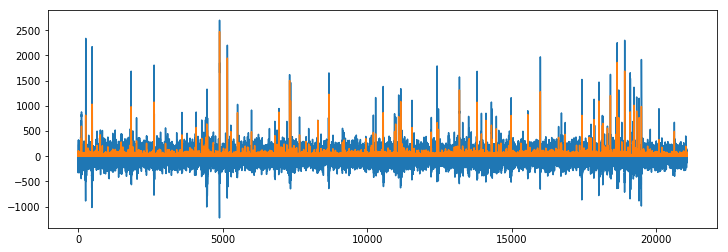

In [6]:
# plot example cell
iN = 100
timerange = np.arange(0, sp.shape[1])
plt.figure(figsize=(12,4))
plt.plot(F0[iN,timerange])
plt.plot(sp[iN,timerange])
plt.show()

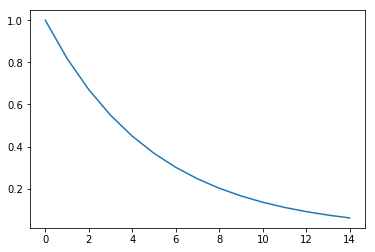

In [7]:
# reconstruct the fluorescence from the deconvolved using the exponential convolution filter
flt  = np.exp(-np.arange(0,3*ops['fs']*ops['tau']) / (ops['tau'] * ops['fs']))
plt.plot(flt)
plt.show()

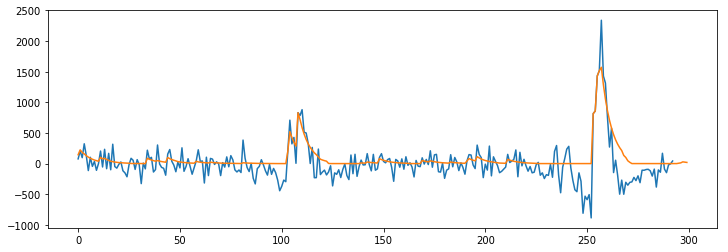

In [8]:
# visualize the reconstruction for neuron iN
iN = 100
timerange = np.arange(0, 300)

# use convolved1d
# convolve spike with its calcium kernel
Frec = convolve1d(sp, flt, axis=1)

tlag = int(len(flt)/2) # timelag from centering convolve1d

plt.figure(figsize=(12,4))
plt.plot(F0[iN,timerange[tlag:]])
plt.plot(Frec[iN,timerange])
plt.show()

In [9]:
# ready to build some models! 
# use T consecutive samples to predict the T+1-th sample

# normalize spike data
# subtract mean for each neuron
sp  = sp - sp.mean(axis=1)[:,np.newaxis]
# divide by the global standard deviation
sp = sp/np.std(sp)

# we will do this prediction one neuron at a time
iN = 1
nt = sp.shape[1]

# let's make windows of size k+2 (where k is how much history we consider)
k = 100
x = np.zeros((nt-k-2,k+2)) # take k+2 consecutive timepoints from sp[iN, :]
for n in range(x.shape[0]):
    x[n,:] = sp[iN, n:n+k+2]

# we predict the last sample
y = x[:, k+1]
# from the first k samples
x = x[:, :k]

# we need to predict x from y
# for regression we need the covariance covX of the inputs
covX = x.T @ x / x.shape[0]

# and the cross-covariance xty between output and input
xty = x.T @ y / x.shape[0]

# linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
w = np.linalg.solve(covX, xty)

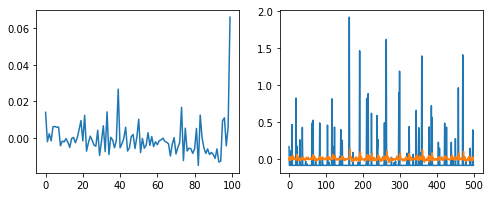

variance explained is 0.01


In [10]:
# now let's plot the filter w, the raw data, and the prediction

# we will make a small function that computes the variance explained
def variance_explained(y,x,w):
    # make variance explained function based on input x, output y, and regression filter w
    ypred = x @ w
    varres = ((y - ypred)**2).mean()
    varexp = 1 - varres / y[:-1].var()    
    return varexp

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1)
ax.plot(w)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(y[:500])
ax2.plot(x[:500,:] @ w)
plt.show()

print('variance explained is %2.2f'%(variance_explained(y,x,w)))

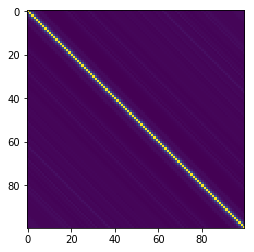

In [11]:
# the covariance in time is a circulant matrix which reflects the autocorrelation function
plt.imshow(covX)
plt.show()

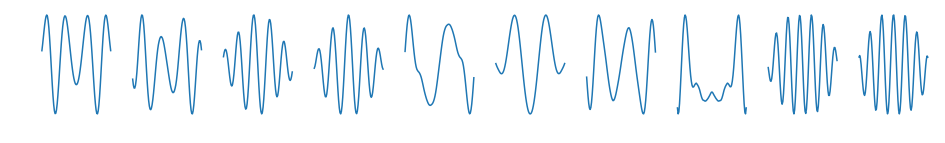

In [12]:
# circulant matrices have PCs which are Fourier modes
# take the eigenvectors ux of covX using scipy.sparse.linalg.eigsh
svx,ux = scipy.sparse.linalg.eigsh(covX,k=covX.shape[1])

fig = plt.figure(figsize=(16,2))
for k in range(10):
    ax = fig.add_subplot(1,10,k+1)
    ax.plot(ux[:,ux.shape[1]-1-k])
    ax.axis('off')

In [13]:
# single neurons are noisy. Let's combine this with PCA
# decompose data into PCs, predict the PCs

# compute principal components
nPCs = 100 # how many PCs to keep
sv,u  = scipy.sparse.linalg.eigsh(sp @ sp.T, k=nPCs)

u = u[:, ::-1] # PCs come in reverse order
# project data into PCs
tracePC = u.T @ sp # use u and sp

# to reconstruct the data and predictions ,we will do
sp_rec = u @ tracePC # use u and trace PC

# the following simply copies the code from above, in a loop for each PC
k = 30
tracePCrec = np.zeros((nPCs,nt-k-1)) # preallocate reconstructed traces
E = np.zeros(nPCs)
for iN in range(nPCs):
    # let's make windows of size k (where k is how much history we consider)
    x = np.zeros((nt-k-1,k+1))
    for n in range(nt-k-1):
        x[n,:] = tracePC[iN, n:n+k+1]
    # we predict the last sample
    y = x[:, k]
    # from the first k samples
    x = x[:, :k]
    # for regression we need the covariance of the inputs
    covX = x.T @ x / x.shape[0]
    # and the cross-covariance between output and input
    xty = x.T @ y / x.shape[0]
    # linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
    w = np.linalg.solve(covX, xty)
    # what is the reconstruction of the PC
    tracePCrec[iN, :] = x @ w
    
    # compute E[iN]. the explained variance for component iN
    E[iN] = 1-((x@w - y)**2).mean()/y.var()

average explained variance is 0.09


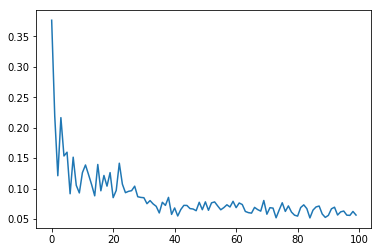

In [14]:
# how much variance is explained in each PC
plt.plot(E)
print('average explained variance is %2.2f'%(E.mean()))
plt.show()
# why do you think it decays as a function of PC#. Make a plot to show it. 

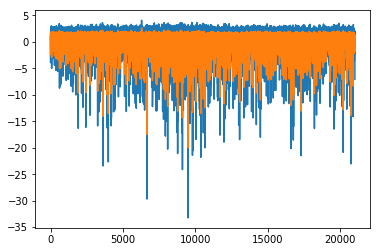

explained variance for PC 0 on this segment is 0.38


In [15]:
# let's plot the reconstructions
iN = 0
NT = tracePC.shape[1]
timerange = np.arange(0, NT-k-1) # plot the whole thing?
#timerange = np.arange(0, 100) zoom in
plt.plot(tracePC[iN, k+timerange]) # we are predicting starting at timepoint k
plt.plot(tracePCrec[iN, timerange])
plt.show()

y = tracePC[iN, k+timerange]
ypred = tracePCrec[iN, timerange]
E0 = 1 - ((y-ypred)**2).mean()/y.var()
print('explained variance for PC %d on this segment is %2.2f'%(iN, E0))


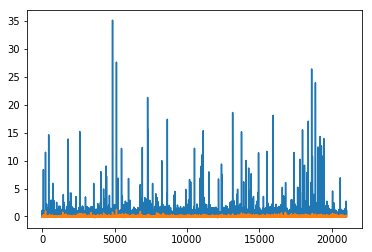

0.015163474944517641


In [16]:
# can we use this to predict single neuron activity? 
sp_rec = u @ tracePCrec # reconstruct single-neuron predictions from u and tracePCrec

# let's plot the reconstructions
iN = 100
NT = tracePC.shape[1]
timerange = np.arange(0, NT-k-1) # plot the whole thing?
#timerange = np.arange(0, 100) zoom in
plt.plot(sp[iN, k+timerange]) # we are predicting starting at timepoint k
plt.plot(sp_rec[iN, timerange])
plt.show()

y = sp[iN, k+timerange]
ypred = sp_rec[iN, timerange]
E = 1 - ((y-ypred)**2).mean()/y.var()
print(E)

# we did not predict as much! what gives? 

In [17]:
# EXTRA
# can we reconstruct the single neuron filters, based on the PC filters? 

# how about using this to predict one neuron from other neurons? can we reconstruct those filters?

In [18]:
# EXTRA
# how many timesamples in the past do we need? make AR(1), AR(2) models. 
# go back above and replace k with 1, 2, 3, etc where does prediction saturate? 


In [19]:
# EXTRA
# Try basis functions instead with timescales of .5, 1, 2, 4 and 8 frames. 
# filter the PCs with exponential filters, predict from those
# no need to window anymore for this: each exponential filter should be applied convolutionally


In [20]:
# EXTRA
# check out the filters learnt: reconstruct them with the basis functions


In [21]:
# EXTRA
# now let's see if we can predict a PC from other PCs. why would we even try this if the PCs are orthogonal?

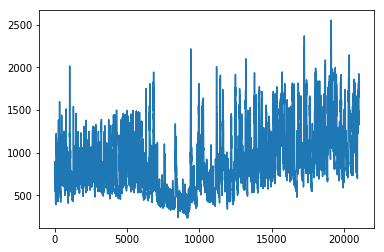

In [22]:
#### add pupil information. First predict only from the pupil, then try basis functions on the pupil
pupil = dat['pupil'].flatten()
plt.plot(pupil)
plt.show()

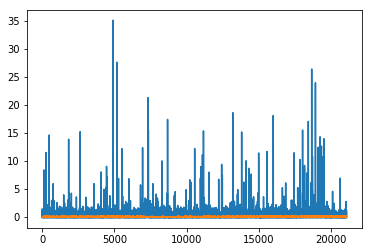

In [23]:
# predict from the pupil

sp -= sp.mean(axis=1)[:,np.newaxis]
pupil -= pupil.mean()
nt = pupil.shape[0]
# use multiple timescales of the pupil
nbasis = 10
pbasis = np.zeros((nt,nbasis))
for n in range(nbasis):
    if n>0:
        pbasis[:,n] = gaussian_filter1d(pupil, n*8)
    else:
        pbasis[:,n] = pupil
        
# linear regression to predict sp from pbasis        
w = np.linalg.solve(pbasis.T @ pbasis, pbasis.T @ sp.T)

# prediction
sp_pred = w.T @ pbasis.T # based on w and pbasis

iN = 100
plt.plot(sp[iN, :])
plt.plot(sp_pred[iN, :])
plt.show()


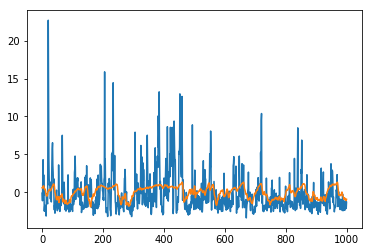

In [24]:
nPCs = 100 # how many PCs to keep
# PCA of covariance matrix of sp
sv,u  = scipy.sparse.linalg.eigsh(sp @ sp.T , k=nPCs) # based on sp

u = u[:, ::-1] # PCs come in reverse order

tracePC = u.T@sp

w = np.linalg.solve(pbasis.T @ pbasis, pbasis.T @ tracePC.T)

tracePCrec = w.T @ pbasis.T

iN = 0
timerange=4000+np.arange(0,1000).astype(int)
plt.plot(tracePC[iN, timerange])
plt.plot(tracePCrec[iN, timerange])
plt.show()

varexp_pupil = 1-((tracePC-tracePCrec)**2).sum(axis=1) / ((tracePC)**2).sum(axis=1)

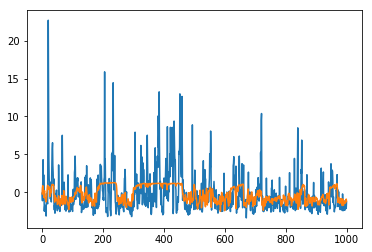

In [25]:
# predicting from the face PCs is better than the basis function pupil prediction
face = dat['faceSVD']

# prediction from face components neural PCs
w = np.linalg.solve(face @ face.T, face @ tracePC.T) # use face and tracePC

tracePCrec = w.T @ face

iN = 0
timerange=4000+np.arange(0,1000).astype(int)
plt.plot(tracePC[iN, timerange])
plt.plot(tracePCrec[iN, timerange])
plt.show()

varexp_face = 1-((tracePC-tracePCrec)**2).sum(axis=1) / ((tracePC)**2).sum(axis=1)


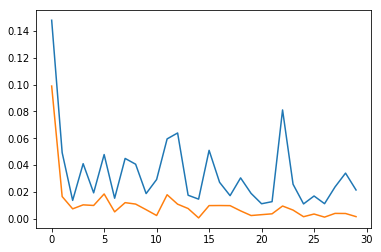

In [26]:
# plt.plot(E[:30]) #(<-- how much you can predict from previous timepts)
plt.plot(varexp_face[:30])
plt.plot(varexp_pupil[:30])
plt.show()

In [27]:
### you could also predict from gaussian filtered face PCs
### or from various timelags of the face PCs
### this might improve prediction

In [28]:
### for extra points, now redo everything with TEST and  TRAINING data